In [1]:
import time
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import tracemalloc
from itertools import product, islice
import memory_profiler as mem_profile
import csv
import greenRed_module as gr
import pinkBlue_module as pb
import recursive_module as rec
import randomCircuit_module as randomCircuit
import statevector_module as sv
import qiskit.quantum_info as qi
import pickle
from memory_profiler import memory_usage


# importing Qiskit
from qiskit import BasicAer
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.aer import AerSimulator

from qiskit.tools.visualization import plot_state_city, plot_histogram

# Random circuit generation

In [3]:
n_qbits=5
depth=5
h_gate_prob=0.5
circ_aux = randomCircuit.random_circuit(n_qbits,depth, h_gate_prob, measure=True)

In [6]:
simulator = Aer.get_backend('statevector_simulator')
# Execute and get counts
result = execute(circ_aux, simulator).result()
statevector = result.get_statevector(circ_aux)
counts = result.get_counts()

In [7]:
def layers_matrix(qc):
    layers=[]
    j=0
    layer=[]
    for gate in qc.data:
        a=[]
        if(len(gate[1]) == 2):
            j=j+2
            name = gate[0].name
            new_name = ''
            for i in name:
                i = i.upper()
                new_name+=i
            if(new_name != 'MEASURE'):
                a.append(new_name)
                a.append(gate[1][0].index)
                a.append(gate[1][1].index)
                layer.append(a)
        else:
            j=j+1
            name = gate[0].name
            new_name = ''
            for i in name:
                i = i.upper()
                new_name+=i
            if(new_name!='MEASURE'):
                a.append(new_name)
                a.append(gate[1][0].index)
                layer.append(a)
        if(j==n_qbits):
            if(layer != []):
                layers.append(layer)
            layer=[]
            j=0
    for i in range(len(layers)):
        layers[i].sort(key=lambda a: a[-1]) 
    return layers

In [8]:
layers=layers_matrix(circ_aux)
print('Layers list: ', layers)
#circ_aux.draw(output='mpl')


Layers list:  [[['H', 0], ['H', 1], ['CX', 2, 3], ['T', 4]], [['T', 0], ['T', 1], ['H', 2], ['T', 3], ['H', 4]], [['CX', 1, 2], ['H', 3], ['CX', 0, 4]], [['H', 0], ['S', 1], ['CX', 2, 3], ['H', 4]], [['H', 0], ['H', 1], ['H', 2], ['H', 3], ['S', 4]]]


<ipython-input-7-b8019c2ae487>:28: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][0].index)
<ipython-input-7-b8019c2ae487>:16: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][0].index)
<ipython-input-7-b8019c2ae487>:17: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][1].index)


## Pre-compilation

In [9]:
def pre_compilation(layers):
    layers_pre_comp = copy.deepcopy(layers)
    wires=[]
    for i in range(n_qbits):
        wire=[]
        wires.append(wire)

    for i in range(depth):
        for gate in layers_pre_comp[i]:
            wires[gate[1]].append(gate[0])
            if(len(gate)==3):
                wires[gate[2]].append(gate[0])

    for j in range(len(wires)):
        for i in range(depth-1):
            if(wires[j][i] == 'H' and wires[j][i+1] == 'H'):
                for gate in layers_pre_comp[i]:
                    if(gate[1]==j):
                        gate[0]='I'
                for gate in layers_pre_comp[i+1]:
                    if(gate[1]==j):
                        gate[0]='I'
                wires[j][i] = 'I'
                wires[j][i+1] = 'I'
    return layers_pre_comp

layers_pre_comp = pre_compilation(layers)
print(layers_pre_comp)

[[['H', 0], ['H', 1], ['CX', 2, 3], ['T', 4]], [['T', 0], ['T', 1], ['H', 2], ['T', 3], ['H', 4]], [['CX', 1, 2], ['H', 3], ['CX', 0, 4]], [['I', 0], ['S', 1], ['CX', 2, 3], ['H', 4]], [['I', 0], ['H', 1], ['H', 2], ['H', 3], ['S', 4]]]


In [10]:
def hRatio(layers):
    num = 0
    den = 0
    for layer in layers:
        for gate in layer:
            den += 1
            if (gate[0]=='H'):
                num += 1
    return (num/den)*100

## Initial State

In [11]:
#POSSIBILITY TO GENERATE A RANDOM INPUT STATE OR CHOOSE AN INPUT STATE MANUALLY
#IF AN INPUT STATE IS CHOSEN MANUALLY, IT MUST HAVE THE FORM state = [q0,q1,q2,...,qn], WITH q0:qn = 0 OR 1 
#AND n=n_qbits-1 

def random_qbits_init(n_qbits, circ_aux):
    stateIn = [random.randint(0,1) for i in range(n_qbits)]
    qc = QuantumCircuit(n_qbits)
    for i in range(n_qbits):
        if (stateIn[i] == 1):
            qc.x(i)
    qc.barrier()
    circ = qc.compose(circ_aux)
    return stateIn, circ

def manual_qbits_init(circ_aux, n_qbits, initial_state):
    qc = QuantumCircuit(n_qbits)
    for i in range(n_qbits):
        if (initial_state[i]==1):
            qc.x(i)
    qc.barrier()
    circ = qc.compose(circ_aux)
    return circ

[1, 1, 0, 0, 0]


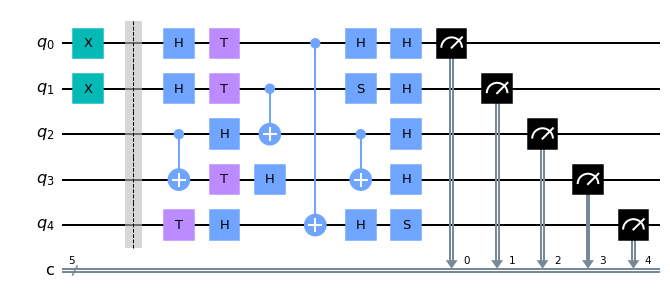

In [12]:
initial_state1, circ1 = random_qbits_init(n_qbits, circ_aux)
print(initial_state1)
circ1.draw(output='mpl')

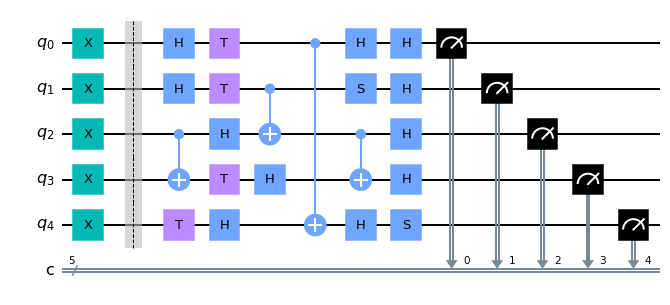

In [14]:
initial_state = [1,1,1,1,1]
circ2 = manual_qbits_init(circ_aux, n_qbits, initial_state)
circ2.draw(output='mpl')

### AUXILIARY FUNCTIONS

In [7]:
def it(max):
    for i in range(1<<max):
        s=bin(i)[2:]
        s='0'*(max-len(s))+s
        s = list(map(int,list(s)))
        yield s

In [8]:
def outputs(max):
    for i in sorted(counts)[:max]:
        out = list(map(int,list(i)))
        yield out

# ALGORITHM VALIDATION

In [23]:
data_list=[]
header = ["% H Gates", "# H Gates pc", "HighestTVD PB", "HighestTVD PB pc",\
          "HighestTVD REC", "HighestTVD REC pc"]

        
def write_csv_from_lists(data, header, filename):
    with open(filename, "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header) # write header
        for row in data:
            csv_writer.writerow(row) # write each row

In [24]:
qcs=[]
start=0
stop=1.01
step=0.25
n_qbits=4
depth=4 

for h_gate_prob in np.arange(start, stop, step):
    for k in range(20):
        #print(n_qbits, depth)
        print('h_prob = ',h_gate_prob)
        highest_tvd_pb=0
        highest_tvd_pb_pc=0
        highest_tvd_rec=0
        highest_tvd_rec_pc=0
        circ_aux = randomCircuit.random_circuit(n_qbits, depth, h_gate_prob, measure=False)
        qcs.append(circ_aux)
        layers=layers_matrix(circ_aux)
        layers_pre_comp = pre_compilation(layers)
        h_ratio = hRatio(layers)
        h_ratio_pc = hRatio(layers_pre_comp)
        tvd_dict_pb = {}
        tvd_dict_pb_pc = {}
        tvd_dict_rec = {}
        tvd_dict_rec_pc = {}
        for i in it(n_qbits):
            input_state=''.join(str(k) for k in i)
            stateIn=copy.deepcopy(i)
            stateIn.reverse()
            qc = manual_qbits_init(circ_aux, n_qbits, stateIn)

            simulator = Aer.get_backend('statevector_simulator')
            # Execute and get counts
            result = execute(qc, simulator).result()
            statevector = result.get_statevector(qc)
            counts = result.get_counts()

            #CREATE OUR OWN COUNTS DICTIONARIES
            counts_feynman_pb={}
            counts_feynman_pb_pc={}
            counts_feynman_rec={}
            counts_feynman_rec_pc={}
            for j in it(n_qbits):
                stateOut=copy.deepcopy(j)
                stateOut.reverse()
                amp_pb = abs(pb.amp_final_PB(stateIn, layers, stateOut, n_qbits))**2
                amp_pb_pc = abs(pb.amp_final_PB(stateIn, layers_pre_comp, stateOut, n_qbits))**2
                amp_rec = abs(rec.amp_final_recursive(layers, 1, stateIn, stateOut, n_qbits))**2
                amp_rec_pc = abs(rec.amp_final_recursive(layers_pre_comp, 1, stateIn, stateOut, n_qbits))**2

                #PB
                if(amp_pb > 0):
                    string=''.join(str(k) for k in j)
                    counts_feynman_pb[string] = amp_pb

                #PB pc
                if(amp_pb_pc > 0):
                    string=''.join(str(k) for k in j)
                    counts_feynman_pb_pc[string] = amp_pb_pc

                #REC 
                if(amp_rec > 0):
                    string=''.join(str(k) for k in j)
                    counts_feynman_rec[string] = amp_rec

                #REC pc
                if(amp_rec_pc > 0):
                    string=''.join(str(k) for k in j)
                    counts_feynman_rec_pc[string] = amp_rec_pc

            counts_feynman_pb = {k:v for (k,v) in counts_feynman_pb.items() if v > math.e**-32}
            counts_feynman_pb_pc = {k:v for (k,v) in counts_feynman_pb_pc.items() if v > math.e**-32}
            counts_feynman_rec = {k:v for (k,v) in counts_feynman_rec.items() if v > math.e**-32}
            counts_feynman_rec_pc = {k:v for (k,v) in counts_feynman_rec_pc.items() if v > math.e**-32}
            
            #DEBUGGING LINES
            #if(counts_feynman_pb.keys() != counts.keys() or len(counts_feynman_pb) != len(counts)):
                #print('ERROR PB!')
                #print(stateIn, stateOut)
                #print(layers)
                #qc_error=circ_aux
                #print(counts)
                #print(counts_feynman_pb)
            #if(counts_feynman_pb_pc.keys() != counts.keys() or len(counts_feynman_pb_pc) != len(counts)):
                #print('ERROR PB pc!')
                #print(stateIn, stateOut)
                #print(layers_pre_comp)
                #qc_error=circ_aux
                #print(counts)
                #print(counts_feynman_pb_pc)
            #if(counts_feynman_rec.keys() != counts.keys() or len(counts_feynman_rec) != len(counts)):
                #print('ERROR REC!')
            #if(counts_feynman_rec_pc.keys() != counts.keys() or len(counts_feynman_rec_pc) != len(counts)):
                #print('ERROR REC pc!')

            #TOTAL VARIATION DISTANCE CALCULATION
            tvd_pb=0
            tvd_pb_pc=0
            tvd_rec=0
            tvd_rec_pc=0
            for key1 in counts:
                tvd_pb += abs(counts_feynman_pb[key1] - counts[key1])/2
                tvd_pb_pc += abs(counts_feynman_pb_pc[key1] - counts[key1])/2
                tvd_rec += abs(counts_feynman_rec[key1] - counts[key1])/2
                tvd_rec_pc += abs(counts_feynman_rec_pc[key1] - counts[key1])/2

            #PB    
            if(tvd_pb > highest_tvd_pb):
                highest_tvd_pb = tvd_pb
                htvd_pb_inState = input_state
            tvd_dict_pb[input_state] = tvd_pb

            #PB pc    
            if(tvd_pb_pc > highest_tvd_pb_pc):
                highest_tvd_pb_pc = tvd_pb_pc
                htvd_pb_pc_inState = input_state
            tvd_dict_pb_pc[input_state] = tvd_pb_pc    
            #REC    
            if(tvd_rec > highest_tvd_rec):
                highest_tvd_rec = tvd_rec
                htvd_rec_inState = input_state
            tvd_dict_rec[input_state] = tvd_rec    
            #REC pc    
            if(tvd_rec_pc > highest_tvd_rec_pc):
                highest_tvd_rec_pc = tvd_rec_pc
                htvd_rec_pc_inState = input_state
            tvd_dict_rec_pc[input_state] = tvd_rec_pc 
            
            #DEBUGGING LINES
            #if(highest_tvd_pb > math.e**-8):
                #print('ERRO PB tvd!')
                #print(stateIn, stateOut)
                #print(layers)
                #qc_error=circ_aux
                #print(counts)
                #print(counts_feynman_pb)
            #if(highest_tvd_pb_pc > math.e**-8):
                #print('ERRO PB pc tvd!')
                #print(stateIn, stateOut)
                #print(layers)
                #print(counts)
                #print(counts_feynman_pb_pc)
                #qc_error=circ_aux

        #print(tvd_dict_pb)
        #print(htvd_pb_inState, highest_tvd_pb)

        #print(tvd_dict_pb_pc)
        #print(htvd_pb_pc_inState, highest_tvd_pb_pc)

        #print(tvd_dict_rec)
        #print(htvd_rec_inState, highest_tvd_rec)

        #print(tvd_dict_rec_pc)
        #print(htvd_rec_pc_inState, highest_tvd_rec_pc)

        data_list.append([h_ratio, h_ratio_pc, highest_tvd_pb, highest_tvd_pb_pc, highest_tvd_rec, highest_tvd_rec_pc])
        
write_csv_from_lists(data_list, header, "SimulatorsValidationFixedqbd.csv")
filename = 'SimulatorsValidationFixedqbd_circuits'
outfile = open(filename,'wb')
pickle.dump(qcs,outfile)
outfile.close()

    

h_prob =  0.0


<ipython-input-5-b8019c2ae487>:28: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][0].index)
<ipython-input-5-b8019c2ae487>:16: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][0].index)
<ipython-input-5-b8019c2ae487>:17: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  a.append(gate[1][1].index)


h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.0
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.25
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.5
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_prob =  0.75
h_pr

### AUXILIARY FUNCTIONS

In [9]:
#FUNÇÕES AUXILIARES PARA OBTER O Nº DE VERMELHOS E ROSAS

def forwardSweep(layers):
    res=[]
    depth = len(layers)
    for i in range(depth-1):
        a=[0 for i in range(n_qbits)]
        for gate in (layers[i]):
            if(i==0):
                if(gate[0]=='S' or gate[0]=='T' or gate[0]=='I'):
                    a[gate[1]]=1
                if(gate[0]=='CX'): 
                    a[gate[1]]=1
                    a[gate[2]]=1
            else:
                if((gate[0]=='S' or gate[0]=='T' or gate[0]=='I') and res[i-1][gate[1]]==1):
                    a[gate[1]]=1
                if(gate[0]=='CX' and res[i-1][gate[1]]==1):
                    a[gate[1]]=1
                if(gate[0]=='CX' and res[i-1][gate[2]]==1 and res[i-1][gate[1]]==1):
                    a[gate[2]]=1
        res.append(a)
    return res

def backwardsSweep(layers):
    res=[]
    depth=len(layers)
    
    for i in range(depth-1):
        a=[0 for i in range(n_qbits)]
        for gate in (layers[depth-1-i]):
            if(i==0):
                if(gate[0]=='S' or gate[0]=='T' or gate[0]=='I'):
                    a[gate[1]]=1
                if(gate[0]=='CX'): 
                    a[gate[1]]=1
                    a[gate[2]]=1
            else:
                if((gate[0]=='S' or gate[0]=='T' or gate[0]=='I') and res[i-1][gate[1]]==1):
                    a[gate[1]]=1
                if(gate[0]=='CX' and res[i-1][gate[1]]==1):
                    a[gate[1]]=1
                if(gate[0]=='CX' and res[i-1][gate[2]]==1 and res[i-1][gate[1]]==1):
                    a[gate[2]]=1
        res.append(a)
    res.reverse()
    return res

def green_and_red_coloring(layers, fs, bs):
    res=[]
    green_and_red_coloring.n_of_reds=0
    for i in range(len(fs)):
        res1=[]
        for color_fs, color_bs in (zip(fs[i], bs[i])):
            if(color_fs==1 or color_bs==1):
                res1.append(1)
            else:
                res1.append(0)
                green_and_red_coloring.n_of_reds+=1
        res.append(res1)
    return res

def pink_and_blue_coloring_front(layers, green_red_color):
    pink_and_blue_coloring_front.n_of_pinks=0
    res=copy.deepcopy(green_red_color)
    depth=len(layers)
    for i in range(depth-1):
        for gate in layers[i]:
            if(gate[0]=='H' and res[i][gate[1]]==0):
                res[i][gate[1]]=2
                pink_and_blue_coloring_front.n_of_pinks+=1
    for i in range(depth-1):
        for j in range(len(res[i])):
            if (res[i][j]==0):
                res[i][j]=3
                
    return res


def outputs(max):
    for i in sorted(counts)[:max]:
        out = list(map(int,list(i)))
        yield out

## PERFORMANCE TESTS

In [11]:
data_list=[]
header = ["N_qbits", "Depth", "Percentage of H gates", "Percentage of H gates pre-comp", "n Reds",\
          "n Reds pre-comp", "n Pinks", "n Pinks pre-comp", "t pb pc", "t rec pc", "mem pb", "mem rec"]

        
def write_csv_from_lists(data, header, filename):
    with open(filename, "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header) # write header
        for row in data:
            csv_writer.writerow(row) # write each row

In [ ]:
#n_qbits/depth range:
qcs=[]
for n in range(10,20):
    n_qbits=n
    depth=4
    for hprob in range(0,5):
        #hprob = random.randint(0, 5)
        h_gate_prob = hprob/100
        print('H prob = ',hprob)
        for circs in range(1):
            circ_aux = randomCircuit.random_circuit(n_qbits, depth, h_gate_prob, measure=False)
            #circ_aux = randomCircuit.random_circuit(n_qbits, depth, h_gate_prob, measure=True) UNCOMMENT WHEN USING THE MPS SIMULATOR
            layers=layers_matrix(circ_aux)
            layers_pre_comp = pre_compilation(layers)
            h_ratio = hRatio(layers)
            h_ratio_pc = hRatio(layers_pre_comp)
            initial_state1 = [0] * n_qbits
            #initial_state1, circ1 = random_qbits_init(n_qbits, circ_aux)
            
            #UNCOMMENT TO USE MPS SIMULATOR
            #simulator = AerSimulator(method='matrix_product_state')
            #tcirc = transpile(circ_aux, simulator)
            #result = simulator.run(tcirc).result()
            #counts = result.get_counts(0)
            #print("mps done")
            #counts

            simulator = Aer.get_backend('statevector_simulator')
            result = execute(circ_aux, simulator).result()
            statevector = result.get_statevector(circ_aux)
            counts = result.get_counts()
            
            coloring_gr = green_and_red_coloring(layers, forwardSweep(layers), backwardsSweep(layers))
            n_of_reds = green_and_red_coloring.n_of_reds
            #reds_ratio = (n_of_reds/(n_qbits * (depth-1)))*100
            coloring_pb = pink_and_blue_coloring_front(layers, coloring_gr)
            n_of_pinks = pink_and_blue_coloring_front.n_of_pinks
            #pinks_ratio = (n_of_pinks/(n_qbits * (depth-1)))*100
            coloring_gr_pre_comp = green_and_red_coloring(layers_pre_comp, forwardSweep(layers_pre_comp), backwardsSweep(layers_pre_comp))
            n_of_reds_pc = green_and_red_coloring.n_of_reds
            #reds_ratio_pc = (n_of_reds_pc/(n_qbits * (depth-1)))*100
            coloring_pb_pre_comp = pink_and_blue_coloring_front(layers_pre_comp, coloring_gr_pre_comp)
            n_of_pinks_pc = pink_and_blue_coloring_front.n_of_pinks
            #pinks_ratio_pc = (n_of_pinks_pc/(n_qbits * (depth-1)))*100
            
            qcs.append(circ_aux)
            #PINK BLUE
           # for j in outputs(1):
            #    out=copy.deepcopy(j)
             #   out.reverse()
              #  start = time.time()
               # tracemalloc.start()
               # pb.amp_final_PB(initial_state1, layers, out, n_qbits)
                #current, peak =  tracemalloc.get_traced_memory()
                #tracemalloc.stop()
                #t_bp = (time.time()-start)
                #memory_bp = peak/1024
            #print('pb done')

            #PINK BLUE PRE COMP
            for j in outputs(1):
                out=copy.deepcopy(j)
                out.reverse()
                start = time.time()
                tracemalloc.start()
                pb.amp_final_PB(initial_state1, layers_pre_comp, out, n_qbits)
                current, peak =  tracemalloc.get_traced_memory()
                tracemalloc.stop()
                t_bp_pc = (time.time()-start)
                memory_bp_pc = peak/1024
            print('pb pre_comp done')

            #RECURSIVE
            #for j in outputs(1):
             #   out=copy.deepcopy(j)
              #  out.reverse()
               # start = time.time()
                #tracemalloc.start()
                #rec.amp_final_recursive(layers, 1, initial_state1, out, n_qbits)
                #current, peak =  tracemalloc.get_traced_memory()
                #tracemalloc.stop()
                #t_rec = (time.time()-start)
                #memory_rec = peak/1024
            #print('rec done')

                #RECURSIVE PRE COMP
            for j in outputs(1):
                out=copy.deepcopy(j)
                out.reverse()
                start = time.time()
                tracemalloc.start()
                rec.amp_final_recursive(layers_pre_comp, 1, initial_state1, out, n_qbits)
                current, peak =  tracemalloc.get_traced_memory()
                tracemalloc.stop()
                t_rec_pc = (time.time()-start)
                memory_rec_pc = peak/1024
            print('rec pre_comp done')
            
            data_list.append([n_qbits, depth, h_ratio, h_ratio_pc, n_of_reds, n_of_reds_pc, \
                          n_of_pinks, n_of_pinks_pc, t_bp_pc, t_rec_pc, memory_bp_pc, memory_rec_pc])
write_csv_from_lists(data_list, header, "csv_file_name.csv")
filename = 'circuits'
outfile = open(filename,'wb')
pickle.dump(qcs,outfile)
outfile.close()

300
H prob =  5
